<a href="https://colab.research.google.com/github/Vhernan123/Notebook-Trabajo-Final-Master/blob/main/evaluacion_hiperparametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
ruta = "/content/drive/MyDrive/mis_archivos_tfm/mi_grilla_original.csv"
base_modelo = pd.read_csv(ruta)
base_modelo.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
base_modelo.columns

Index(['sector_id', 'fecha', 'delitos_total', 'delitos_con_arma', 'edad_media',
       'prop_mujer', 'delitos_total_lag1', 'delitos_con_arma_lag1',
       'delitos_total_lag2', 'delitos_con_arma_lag2', 'delitos_total_lag3',
       'delitos_con_arma_lag3', 'delitos_total_lag4', 'delitos_con_arma_lag4',
       'delitos_total_lag5', 'delitos_con_arma_lag5', 'delitos_total_lag6',
       'delitos_con_arma_lag6', 'delitos_total_lag7', 'delitos_con_arma_lag7',
       'anio', 'mes', 'dia_semana', 'es_fin_semana', 'y_reg'],
      dtype='object')

# random forest

## Profundidad del arbol (max_depth)

Shape después de cargar y filtrar y_reg: (41328, 25)
Resumen de y_reg:
count    41328.000000
mean        24.142131
std         12.358817
min          0.000000
25%         17.000000
50%         25.000000
75%         32.000000
max        325.000000
Name: y_reg, dtype: float64

Fecha de corte (train hasta aquí): 2024-04-30T00:00:00.000000000
Tamaño train: (33075, 10)  | Tamaño test: (8253, 10)

--- Entrenando RandomForest con max_depth=10 ---
Train -> MAE: 5.0430 | RMSE: 6.6338 | R²: 0.5068
Test  -> MAE: 5.7499 | RMSE: 6.6526 | R²: 0.2603

--- Entrenando RandomForest con max_depth=30 ---
Train -> MAE: 2.1037 | RMSE: 2.8865 | R²: 0.9066
Test  -> MAE: 5.5300 | RMSE: 6.3963 | R²: 0.3162

--- Entrenando RandomForest con max_depth=50 ---
Train -> MAE: 2.0987 | RMSE: 2.8815 | R²: 0.9069
Test  -> MAE: 5.5307 | RMSE: 6.3967 | R²: 0.3162

--- Entrenando RandomForest con max_depth=90 ---
Train -> MAE: 2.0987 | RMSE: 2.8815 | R²: 0.9069
Test  -> MAE: 5.5307 | RMSE: 6.3967 | R²: 0.3162

--- Entrenand

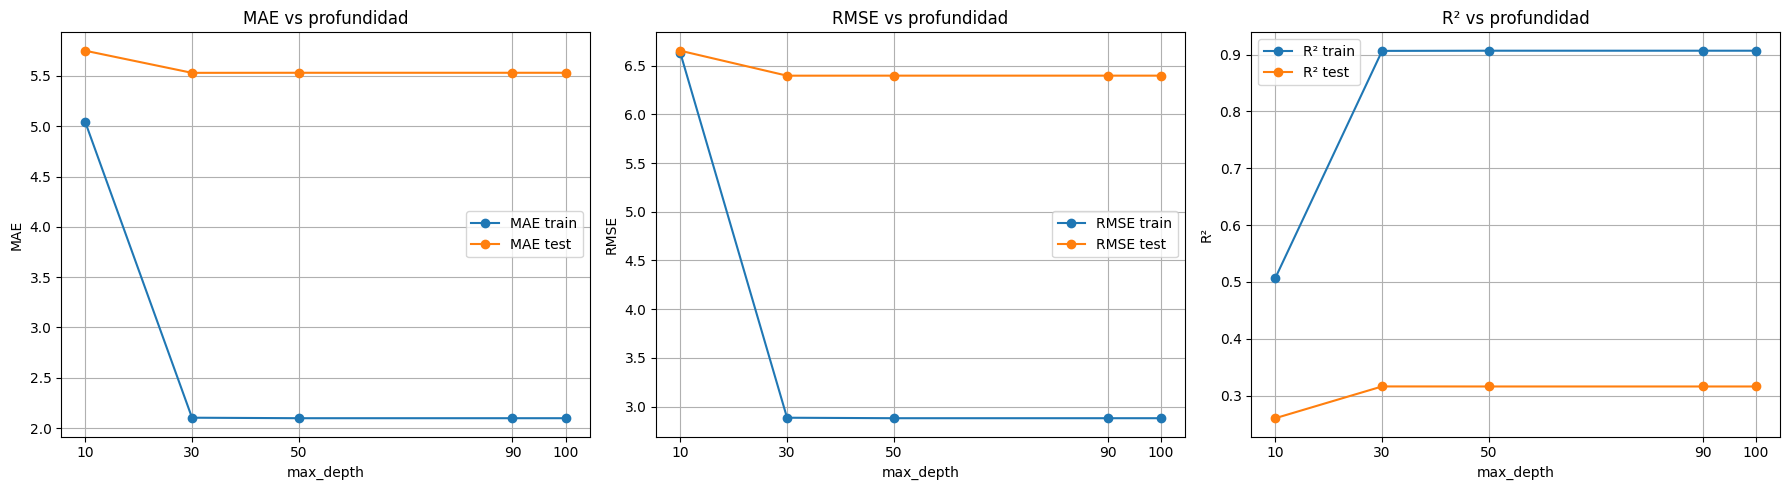


Profundidad 'óptima' según MAE de test: max_depth = 30

=== IMPORTANCIA DE VARIABLES (RF, max_depth=30) ===
             variable  importancia
2  delitos_total_lag1     0.187264
7  delitos_total_lag6     0.136238
1          prop_mujer     0.117165
0          edad_media     0.101857
3  delitos_total_lag2     0.093129
8  delitos_total_lag7     0.090638
5  delitos_total_lag4     0.089824
6  delitos_total_lag5     0.089468
4  delitos_total_lag3     0.083316
9       es_fin_semana     0.011101


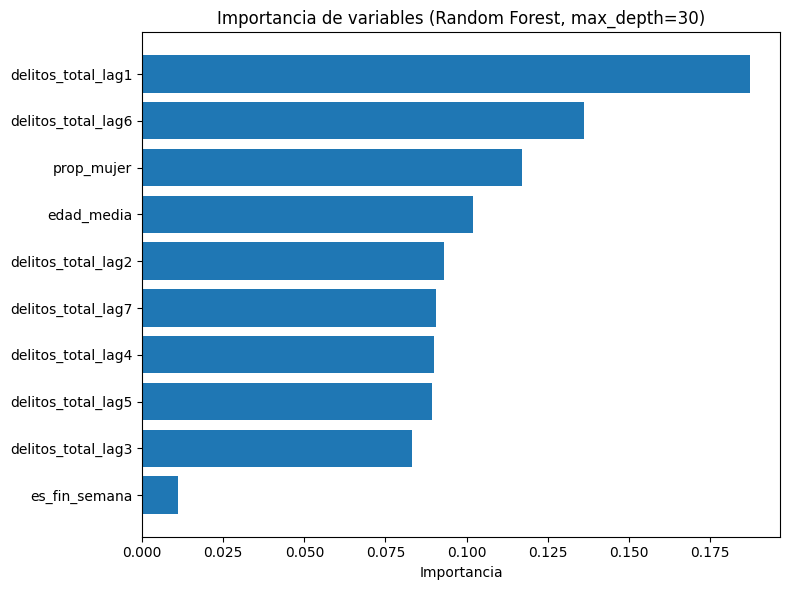

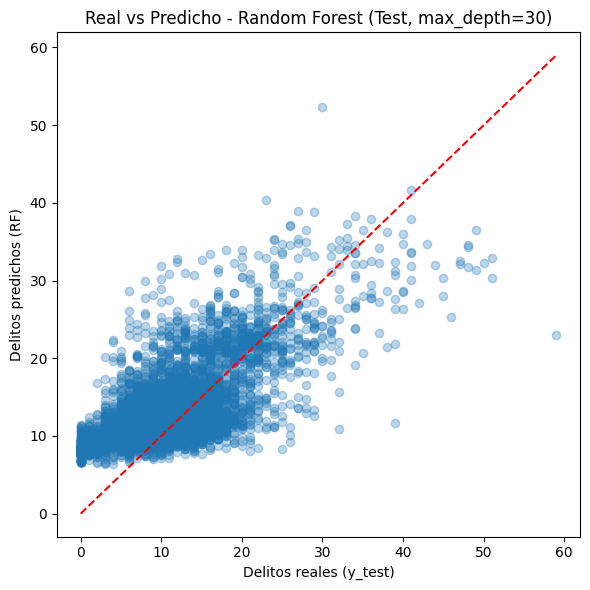

In [ ]:
# ============================================
# 0. IMPORTS
# ============================================


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# ============================================
# 1. CARGAR GRILLA DESDE CSV
#    (ya incluye la columna objetivo y_reg)
# ============================================

# Se asume que base_modelo ya está en memoria
dfm = base_modelo.copy()

# Asegurar tipo datetime en fecha
dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")

# Ordenar por sector y fecha
dfm = dfm.sort_values(["sector_id", "fecha"])

# Eliminar filas donde falte la target (por seguridad)
dfm = dfm.dropna(subset=["y_reg"]).copy()

print("Shape después de cargar y filtrar y_reg:", dfm.shape)
print("Resumen de y_reg:")
print(dfm["y_reg"].describe())

# ============================================
# 2. DEFINIR VARIABLES PREDICTORAS Y TARGET
#    Usamos SOLO lags + covariables (no el delito del día actual)
# ============================================

features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",
    "delitos_total_lag2",
    "delitos_total_lag3",
    "delitos_total_lag4",
    "delitos_total_lag5",
    "delitos_total_lag6",
    "delitos_total_lag7",

    "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]      # ← aquí usamos directamente la columna del CSV

# ============================================
# 3. SPLIT TEMPORAL: 80% de las fechas para TRAIN, 20% para TEST
# ============================================

fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

print("\nFecha de corte (train hasta aquí):", fecha_corte)

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Tamaño train:", X_train.shape, " | Tamaño test:", X_test.shape)

# ============================================
# 4. BÚSQUEDA MANUAL DE max_depth PARA RANDOM FOREST
# ============================================

depths = [10, 30, 50, 90, 100]

mae_train_list = []
mae_test_list  = []
rmse_train_list = []
rmse_test_list  = []
r2_train_list  = []
r2_test_list   = []

for d in depths:
    print(f"\n--- Entrenando RandomForest con max_depth={d} ---")

    pipe_rf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(
                n_estimators=300,
                max_depth=d,
                random_state=42,
                n_jobs=-1
            ))
    ])

    pipe_rf.fit(X_train, y_train)

    # Predicciones
    y_pred_train = pipe_rf.predict(X_train)
    y_pred_test  = pipe_rf.predict(X_test)

    # Métricas
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test,  y_pred_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(y_test,  y_pred_test))

    r2_train  = r2_score(y_train, y_pred_train)
    r2_test   = r2_score(y_test,  y_pred_test)

    mae_train_list.append(mae_train)
    mae_test_list.append(mae_test)
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)

    print(f"Train -> MAE: {mae_train:.4f} | RMSE: {rmse_train:.4f} | R²: {r2_train:.4f}")
    print(f"Test  -> MAE: {mae_test:.4f} | RMSE: {rmse_test:.4f} | R²: {r2_test:.4f}")

# ============================================
# 5. SUBPLOTS HORIZONTALES: MAE, RMSE y R² vs PROFUNDIDAD
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# --- MAE ---
axes[0].plot(depths, mae_train_list, marker="o", label="MAE train")
axes[0].plot(depths, mae_test_list,  marker="o", label="MAE test")
axes[0].set_title("MAE vs profundidad")
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("MAE")
axes[0].grid(True)
axes[0].legend()

# --- RMSE ---
axes[1].plot(depths, rmse_train_list, marker="o", label="RMSE train")
axes[1].plot(depths, rmse_test_list,  marker="o", label="RMSE test")
axes[1].set_title("RMSE vs profundidad")
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("RMSE")
axes[1].grid(True)
axes[1].legend()

# --- R² ---
axes[2].plot(depths, r2_train_list, marker="o", label="R² train")
axes[2].plot(depths, r2_test_list,  marker="o", label="R² test")
axes[2].set_title("R² vs profundidad")
axes[2].set_xlabel("max_depth")
axes[2].set_ylabel("R²")
axes[2].grid(True)
axes[2].legend()

plt.xticks(depths)
plt.tight_layout()
plt.show()


# ============================================
# 6. (OPCIONAL) SI QUIERES, PUEDES SEGUIR USANDO ESTO:
#    Elegir profundidad óptima y entrenar modelo final
# ============================================

best_idx = int(np.argmin(mae_test_list))
best_depth = depths[best_idx]
print(f"\nProfundidad 'óptima' según MAE de test: max_depth = {best_depth}")

pipe_rf_best = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(
            n_estimators=300,
            max_depth=best_depth,
            random_state=42,
            n_jobs=-1
        ))
])

pipe_rf_best.fit(X_train, y_train)

# ============================================
# 7. IMPORTANCIA DE VARIABLES (RF FINAL)
# ============================================

rf_model = pipe_rf_best.named_steps["rf"]

importancias = rf_model.feature_importances_
importancias_df = (
    pd.DataFrame({
        "variable": features,
        "importancia": importancias
    })
    .sort_values("importancia", ascending=False)
)

print("\n=== IMPORTANCIA DE VARIABLES (RF, max_depth="
      + str(best_depth) + ") ===")
print(importancias_df)

plt.figure(figsize=(8, 6))
plt.barh(importancias_df["variable"][::-1],
         importancias_df["importancia"][::-1])
plt.xlabel("Importancia")
plt.title(f"Importancia de variables (Random Forest, max_depth={best_depth})")
plt.tight_layout()
plt.show()

# ============================================
# 8. GRÁFICO REAL vs PREDICHO (TEST) PARA RF FINAL
# ============================================

y_pred_test_rf = pipe_rf_best.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test_rf, alpha=0.3)
max_val = max(y_test.max(), y_pred_test_rf.max())
plt.plot([0, max_val], [0, max_val], "r--")  # línea 45°
plt.xlabel("Delitos reales (y_test)")
plt.ylabel("Delitos predichos (RF)")
plt.title(f"Real vs Predicho - Random Forest (Test, max_depth={best_depth})")
plt.tight_layout()
plt.show()


eleccion de variables optimas

## Ajuste de n_estimator

Shape después de filtrar: (41328, 25)
count    41328.000000
mean        24.142131
std         12.358817
min          0.000000
25%         17.000000
50%         25.000000
75%         32.000000
max        325.000000
Name: y_reg, dtype: float64
Train: (33075, 20) Test: (8253, 20)

=== Entrenando RF con n_estimators=50 ===

=== Entrenando RF con n_estimators=100 ===

=== Entrenando RF con n_estimators=200 ===

=== Entrenando RF con n_estimators=300 ===

=== Entrenando RF con n_estimators=400 ===

=== Entrenando RF con n_estimators=500 ===


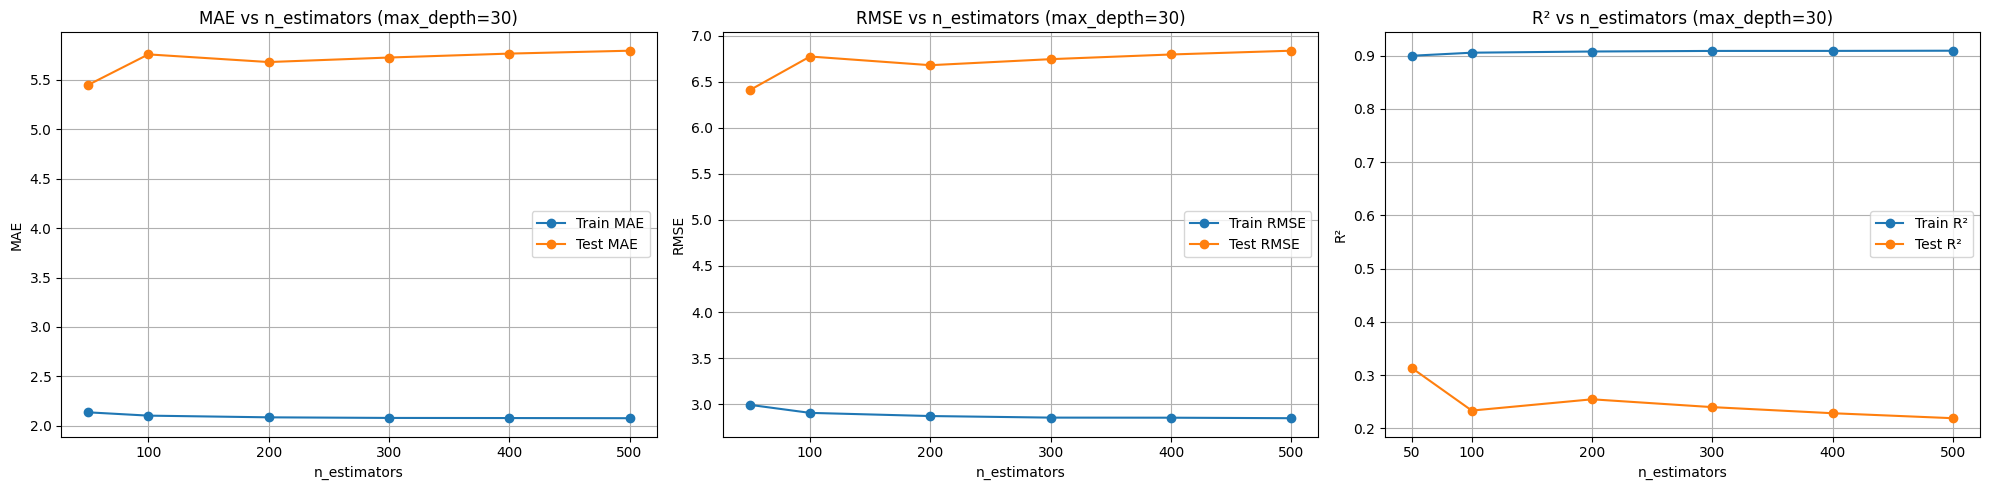

In [ ]:
# ============================================
# 0. IMPORTS
# ============================================
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# ============================================
# 1. PREPARAR GRILLA
# ============================================

dfm = base_modelo.copy()

dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")
dfm = dfm.sort_values(["sector_id", "fecha"])
dfm = dfm.dropna(subset=["y_reg"]).copy()

print("Shape después de filtrar:", dfm.shape)
print(dfm["y_reg"].describe())

# Variables predictoras
features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",    "delitos_con_arma_lag1",
    "delitos_total_lag2",    "delitos_con_arma_lag2",
    "delitos_total_lag3",    "delitos_con_arma_lag3",
    "delitos_total_lag4",    "delitos_con_arma_lag4",
    "delitos_total_lag5",    "delitos_con_arma_lag5",
    "delitos_total_lag6",    "delitos_con_arma_lag6",
    "delitos_total_lag7",    "delitos_con_arma_lag7",

    "anio", "mes", "dia_semana", "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# ============================================
# 2. SPLIT TEMPORAL
# ============================================

fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Train:", X_train.shape, "Test:", X_test.shape)

# ============================================
# 3. EXPERIMENTO: VARIAR n_estimators
# ============================================

n_estimators_list = [50, 100, 200, 300, 400, 500]

mae_train_list = []
mae_test_list  = []
rmse_train_list = []
rmse_test_list  = []
r2_train_list  = []
r2_test_list   = []

max_depth_fijo = 30  # profundidad fija

for n_est in n_estimators_list:
    print(f"\n=== Entrenando RF con n_estimators={n_est} ===")

    pipe_rf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("rf", RandomForestRegressor(
                n_estimators=n_est,
                max_depth=max_depth_fijo,
                random_state=42,
                n_jobs=-1
            ))
    ])

    pipe_rf.fit(X_train, y_train)

    y_pred_train = pipe_rf.predict(X_train)
    y_pred_test  = pipe_rf.predict(X_test)

    # Métricas
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test,  y_pred_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(y_test,  y_pred_test))

    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test,  y_pred_test)

    mae_train_list.append(mae_train)
    mae_test_list.append(mae_test)
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)

# ============================================
# 4. SUBPLOTS HORIZONTALES
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ------------ MAE ------------
axes[0].plot(n_estimators_list, mae_train_list, marker="o", label="Train MAE")
axes[0].plot(n_estimators_list, mae_test_list, marker="o", label="Test MAE")
axes[0].set_title(f"MAE vs n_estimators (max_depth={max_depth_fijo})")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("MAE")
axes[0].grid(True)
axes[0].legend()

# ------------ RMSE ------------
axes[1].plot(n_estimators_list, rmse_train_list, marker="o", label="Train RMSE")
axes[1].plot(n_estimators_list, rmse_test_list, marker="o", label="Test RMSE")
axes[1].set_title(f"RMSE vs n_estimators (max_depth={max_depth_fijo})")
axes[1].set_xlabel("n_estimators")
axes[1].set_ylabel("RMSE")
axes[1].grid(True)
axes[1].legend()

# ------------ R² ------------
axes[2].plot(n_estimators_list, r2_train_list, marker="o", label="Train R²")
axes[2].plot(n_estimators_list, r2_test_list, marker="o", label="Test R²")
axes[2].set_title(f"R² vs n_estimators (max_depth={max_depth_fijo})")
axes[2].set_xlabel("n_estimators")
axes[2].set_ylabel("R²")
axes[2].grid(True)
axes[2].legend()

plt.xticks(n_estimators_list)
plt.tight_layout()
plt.show()
fig.savefig("/content/imagen_metricas.png", dpi=300, bbox_inches='tight')


---

## Ajuste de min_samples_leaf

___

# LightGBMRegressor

## n_leaves

Train: (33075, 20)  Test: (8253, 20)

=== Entrenando LightGBM con num_leaves=7 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con num_leaves=10 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con num_leaves=15 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con num_leaves=20 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con num_leaves=30 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con num_leaves=50 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con num_leaves=80 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con num_leaves=100 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


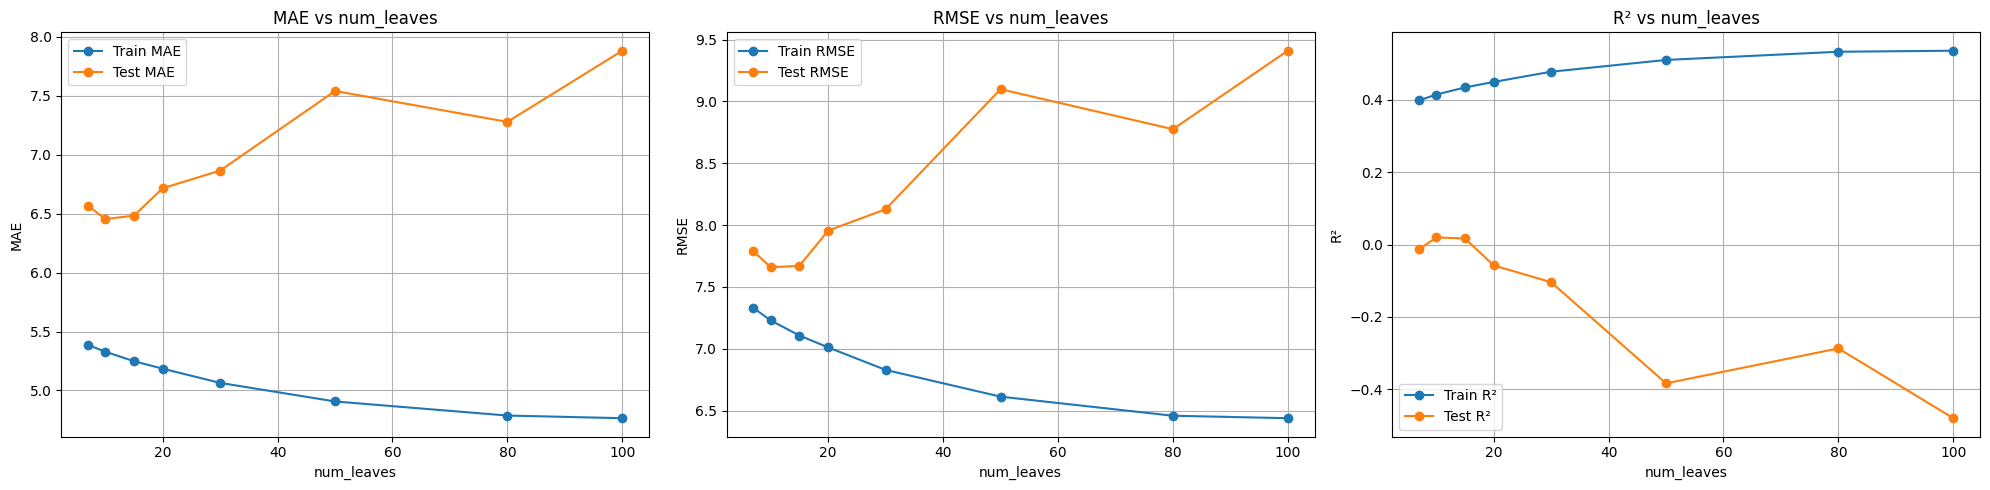


Mejor num_leaves según MAE test: 10


In [ ]:
# ============================================
# 0. IMPORTS
# ============================================
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

# ============================================
# 1. PREPARAR GRILLA BASE
# ============================================
dfm = base_modelo.copy()

dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")
dfm = dfm.sort_values(["sector_id", "fecha"])
dfm = dfm.dropna(subset=["y_reg"]).copy()

# Variables predictoras
features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",  "delitos_con_arma_lag1",
    "delitos_total_lag2",  "delitos_con_arma_lag2",
    "delitos_total_lag3",  "delitos_con_arma_lag3",
    "delitos_total_lag4",  "delitos_con_arma_lag4",
    "delitos_total_lag5",  "delitos_con_arma_lag5",
    "delitos_total_lag6",  "delitos_con_arma_lag6",
    "delitos_total_lag7",  "delitos_con_arma_lag7",

    "anio", "mes", "dia_semana", "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# ============================================
# 2. SPLIT TEMPORAL 80/20
# ============================================
fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Train:", X_train.shape, " Test:", X_test.shape)

# ============================================
# 3. EXPERIMENTO: num_leaves
# ============================================
leaves_values = [7, 10, 15, 20, 30, 50, 80, 100]

mae_train_list = []
mae_test_list  = []
rmse_train_list = []
rmse_test_list  = []
r2_train_list  = []
r2_test_list   = []

# Parámetros fijos
max_depth_fijo = 7
learning_rate_fijo = 0.05
n_estimators_fijo = 300

for leaves in leaves_values:
    print(f"\n=== Entrenando LightGBM con num_leaves={leaves} ===")

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("lgbm", LGBMRegressor(
                num_leaves=leaves,
                max_depth=max_depth_fijo,
                learning_rate=learning_rate_fijo,
                n_estimators=n_estimators_fijo,
                random_state=42,
                n_jobs=-1
        ))
    ])

    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    mae_train_list.append(mean_absolute_error(y_train, y_pred_train))
    mae_test_list.append(mean_absolute_error(y_test,  y_pred_test))

    rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    rmse_test_list.append(np.sqrt(mean_squared_error(y_test,  y_pred_test)))

    r2_train_list.append(r2_score(y_train, y_pred_train))
    r2_test_list.append(r2_score(y_test,  y_pred_test))

# ============================================
# 4. SUBPLOTS HORIZONTALES
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ------------ MAE ------------
axes[0].plot(leaves_values, mae_train_list, marker="o", label="Train MAE")
axes[0].plot(leaves_values, mae_test_list,  marker="o", label="Test MAE")
axes[0].set_title("MAE vs num_leaves")
axes[0].set_xlabel("num_leaves")
axes[0].set_ylabel("MAE")
axes[0].grid(True)
axes[0].legend()

# ------------ RMSE ------------
axes[1].plot(leaves_values, rmse_train_list, marker="o", label="Train RMSE")
axes[1].plot(leaves_values, rmse_test_list,  marker="o", label="Test RMSE")
axes[1].set_title("RMSE vs num_leaves")
axes[1].set_xlabel("num_leaves")
axes[1].set_ylabel("RMSE")
axes[1].grid(True)
axes[1].legend()

# ------------ R² ------------
axes[2].plot(leaves_values, r2_train_list, marker="o", label="Train R²")
axes[2].plot(leaves_values, r2_test_list,  marker="o", label="Test R²")
axes[2].set_title("R² vs num_leaves")
axes[2].set_xlabel("num_leaves")
axes[2].set_ylabel("R²")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()

# ============================================
# 4B. EXPORTACIÓN VECTORIAL (SVG)
# ============================================
plt.savefig("lightgbm_experimento_num_leaves.svg", format="svg", bbox_inches="tight")

# (Opcional) Exportar también a PDF o PNG nítido:
# plt.savefig("lightgbm_experimento_num_leaves.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("lightgbm_experimento_num_leaves.png", dpi=300, bbox_inches="tight")

plt.show()

# ============================================
# 5. IMPRIMIR EL ÓPTIMO SEGÚN MAE TEST
# ============================================
best_idx = int(np.argmin(mae_test_list))
best_leaves = leaves_values[best_idx]

print(f"\nMejor num_leaves según MAE test: {best_leaves}")


## Max_depth

Train: (33075, 20)  Test: (8253, 20)

=== Entrenando LightGBM con max_depth=3 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con max_depth=5 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con max_depth=7 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con max_depth=9 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con max_depth=11 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con max_depth=15 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con max_depth=-1 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


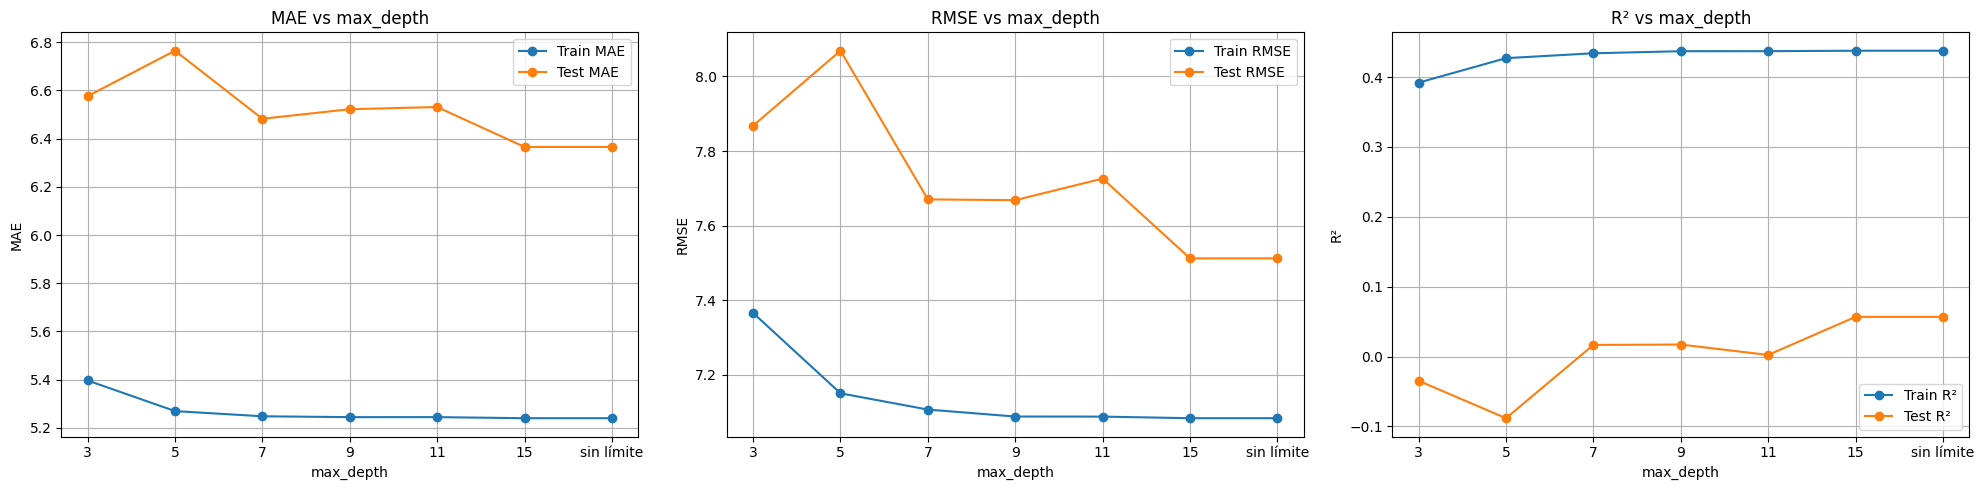


Mejor max_depth según MAE test: 15


In [ ]:
# ============================================
# 0. IMPORTS
# ============================================
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

# ============================================
# 1. PREPARAR GRILLA BASE
# ============================================
dfm = base_modelo.copy()

dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")
dfm = dfm.sort_values(["sector_id", "fecha"])
dfm = dfm.dropna(subset=["y_reg"]).copy()

# Variables predictoras
features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",  "delitos_con_arma_lag1",
    "delitos_total_lag2",  "delitos_con_arma_lag2",
    "delitos_total_lag3",  "delitos_con_arma_lag3",
    "delitos_total_lag4",  "delitos_con_arma_lag4",
    "delitos_total_lag5",  "delitos_con_arma_lag5",
    "delitos_total_lag6",  "delitos_con_arma_lag6",
    "delitos_total_lag7",  "delitos_con_arma_lag7",

    "anio", "mes", "dia_semana", "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# ============================================
# 2. SPLIT TEMPORAL 80/20
# ============================================
fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Train:", X_train.shape, " Test:", X_test.shape)

# ============================================
# 3. EXPERIMENTO: max_depth
# ============================================
# Profundidades a probar
max_depth_values = [3, 5, 7, 9, 11, 15, -1]  # -1 = sin límite

mae_train_list = []
mae_test_list  = []
rmse_train_list = []
rmse_test_list  = []
r2_train_list  = []
r2_test_list   = []

# Parámetros fijos (puedes poner aquí el num_leaves óptimo que ya encontraste)
num_leaves_fijo = 15
learning_rate_fijo = 0.05
n_estimators_fijo = 300

for depth in max_depth_values:
    print(f"\n=== Entrenando LightGBM con max_depth={depth} ===")

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("lgbm", LGBMRegressor(
                num_leaves=num_leaves_fijo,
                max_depth=depth,
                learning_rate=learning_rate_fijo,
                n_estimators=n_estimators_fijo,
                random_state=42,
                n_jobs=-1
        ))
    ])

    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    mae_train_list.append(mean_absolute_error(y_train, y_pred_train))
    mae_test_list.append(mean_absolute_error(y_test,  y_pred_test))

    rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    rmse_test_list.append(np.sqrt(mean_squared_error(y_test,  y_pred_test)))

    r2_train_list.append(r2_score(y_train, y_pred_train))
    r2_test_list.append(r2_score(y_test,  y_pred_test))

# ============================================
# 4. SUBPLOTS HORIZONTALES
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Para el eje X, convertimos -1 a string "sin límite" para que se lea mejor
x_labels = [str(d) if d != -1 else "sin límite" for d in max_depth_values]
x_pos = np.arange(len(max_depth_values))

# ------------ MAE ------------
axes[0].plot(x_pos, mae_train_list, marker="o", label="Train MAE")
axes[0].plot(x_pos, mae_test_list,  marker="o", label="Test MAE")
axes[0].set_title("MAE vs max_depth")
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("MAE")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)
axes[0].grid(True)
axes[0].legend()

# ------------ RMSE ------------
axes[1].plot(x_pos, rmse_train_list, marker="o", label="Train RMSE")
axes[1].plot(x_pos, rmse_test_list,  marker="o", label="Test RMSE")
axes[1].set_title("RMSE vs max_depth")
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("RMSE")
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].grid(True)
axes[1].legend()

# ------------ R² ------------
axes[2].plot(x_pos, r2_train_list, marker="o", label="Train R²")
axes[2].plot(x_pos, r2_test_list,  marker="o", label="Test R²")
axes[2].set_title("R² vs max_depth")
axes[2].set_xlabel("max_depth")
axes[2].set_ylabel("R²")
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(x_labels)
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()

# ============================================
# 4B. EXPORTACIÓN VECTORIAL (SVG)
# ============================================
plt.savefig("lightgbm_experimento_max_depth.svg", format="svg", bbox_inches="tight")

# (Opcional) Exportar también a PDF o PNG nítido:
# plt.savefig("lightgbm_experimento_max_depth.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("lightgbm_experimento_max_depth.png", dpi=300, bbox_inches="tight")

plt.show()

# ============================================
# 5. IMPRIMIR EL ÓPTIMO SEGÚN MAE TEST
# ============================================
best_idx = int(np.argmin(mae_test_list))
best_depth = max_depth_values[best_idx]

print(f"\nMejor max_depth según MAE test: {best_depth}")


## Learning_rate

Train: (33075, 20)  Test: (8253, 20)

=== Entrenando LightGBM con learning_rate=0.001 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con learning_rate=0.01 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con learning_rate=0.03 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con learning_rate=0.05 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con learning_rate=0.1 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con learning_rate=0.2 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


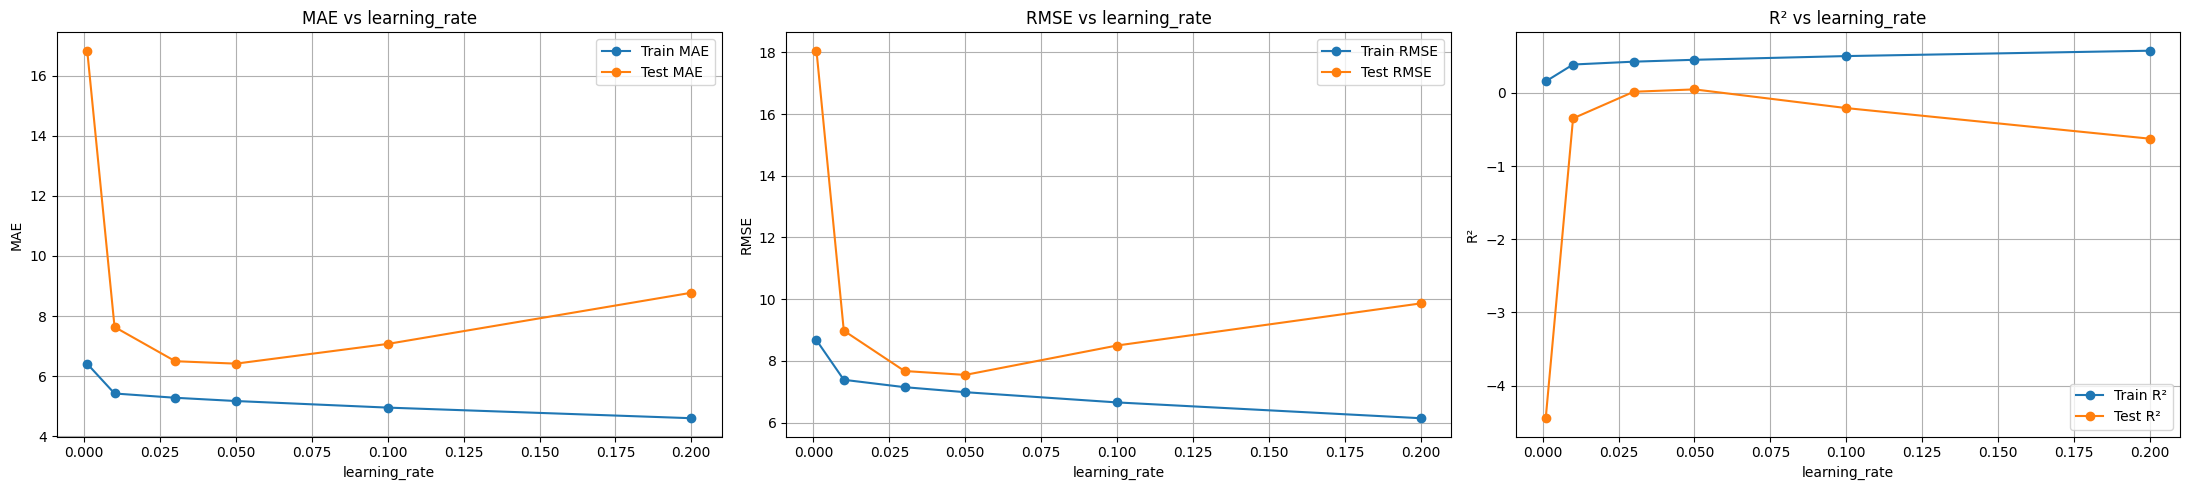


Mejor learning_rate según MAE test: 0.05


In [ ]:
# ============================================
# 0. IMPORTS
# ============================================
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

# ============================================
# 1. PREPARAR GRILLA BASE
# ============================================
dfm = base_modelo.copy()

dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")
dfm = dfm.sort_values(["sector_id", "fecha"])
dfm = dfm.dropna(subset=["y_reg"]).copy()

# Variables predictoras
features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",  "delitos_con_arma_lag1",
    "delitos_total_lag2",  "delitos_con_arma_lag2",
    "delitos_total_lag3",  "delitos_con_arma_lag3",
    "delitos_total_lag4",  "delitos_con_arma_lag4",
    "delitos_total_lag5",  "delitos_con_arma_lag5",
    "delitos_total_lag6",  "delitos_con_arma_lag6",
    "delitos_total_lag7",  "delitos_con_arma_lag7",

    "anio", "mes", "dia_semana", "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# ============================================
# 2. SPLIT TEMPORAL 80/20
# ============================================
fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Train:", X_train.shape, " Test:", X_test.shape)

# ============================================
# 3. EXPERIMENTO: learning_rate
# ============================================
learning_rates = [0.001, 0.01, 0.03, 0.05, 0.1, 0.2]

mae_train_list = []
mae_test_list  = []
rmse_train_list = []
rmse_test_list  = []
r2_train_list  = []
r2_test_list   = []

# Parámetros fijos (pon aquí los óptimos ya encontrados)
num_leaves_fijo = 15
max_depth_fijo = 15
n_estimators_fijo = 400  # Importante: aumentar n_estimators para LR pequeños

for lr in learning_rates:
    print(f"\n=== Entrenando LightGBM con learning_rate={lr} ===")

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("lgbm", LGBMRegressor(
                num_leaves=num_leaves_fijo,
                max_depth=max_depth_fijo,
                learning_rate=lr,
                n_estimators=n_estimators_fijo,
                random_state=42,
                n_jobs=-1
        ))
    ])

    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    mae_train_list.append(mean_absolute_error(y_train, y_pred_train))
    mae_test_list.append(mean_absolute_error(y_test,  y_pred_test))

    rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    rmse_test_list.append(np.sqrt(mean_squared_error(y_test,  y_pred_test)))

    r2_train_list.append(r2_score(y_train, y_pred_train))
    r2_test_list.append(r2_score(y_test,  y_pred_test))

# ============================================
# 4. SUBPLOTS HORIZONTALES
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

# ------------ MAE ------------
axes[0].plot(learning_rates, mae_train_list, marker="o", label="Train MAE")
axes[0].plot(learning_rates, mae_test_list,  marker="o", label="Test MAE")
axes[0].set_title("MAE vs learning_rate")
axes[0].set_xlabel("learning_rate")
axes[0].set_ylabel("MAE")
axes[0].grid(True)
axes[0].legend()

# ------------ RMSE ------------
axes[1].plot(learning_rates, rmse_train_list, marker="o", label="Train RMSE")
axes[1].plot(learning_rates, rmse_test_list,  marker="o", label="Test RMSE")
axes[1].set_title("RMSE vs learning_rate")
axes[1].set_xlabel("learning_rate")
axes[1].set_ylabel("RMSE")
axes[1].grid(True)
axes[1].legend()

# ------------ R² ------------
axes[2].plot(learning_rates, r2_train_list, marker="o", label="Train R²")
axes[2].plot(learning_rates, r2_test_list,  marker="o", label="Test R²")
axes[2].set_title("R² vs learning_rate")
axes[2].set_xlabel("learning_rate")
axes[2].set_ylabel("R²")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()

# ============================================
# 4B. EXPORTACIÓN VECTORIAL (SVG)
# ============================================
plt.savefig("lightgbm_experimento_learning_rate.svg", format="svg", bbox_inches="tight")

plt.show()

# ============================================
# 5. IMPRIMIR EL ÓPTIMO SEGÚN MAE TEST
# ============================================
best_idx = int(np.argmin(mae_test_list))
best_lr = learning_rates[best_idx]

print(f"\nMejor learning_rate según MAE test: {best_lr}")


## n_estimators

Train: (33075, 20)  Test: (8253, 20)

=== Entrenando LightGBM con n_estimators=50 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con n_estimators=100 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con n_estimators=200 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con n_estimators=400 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con n_estimators=600 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Entrenando LightGBM con n_estimators=800 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 33075, number of used features: 20
[LightGBM] [Info] Start training from score 28.302766


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


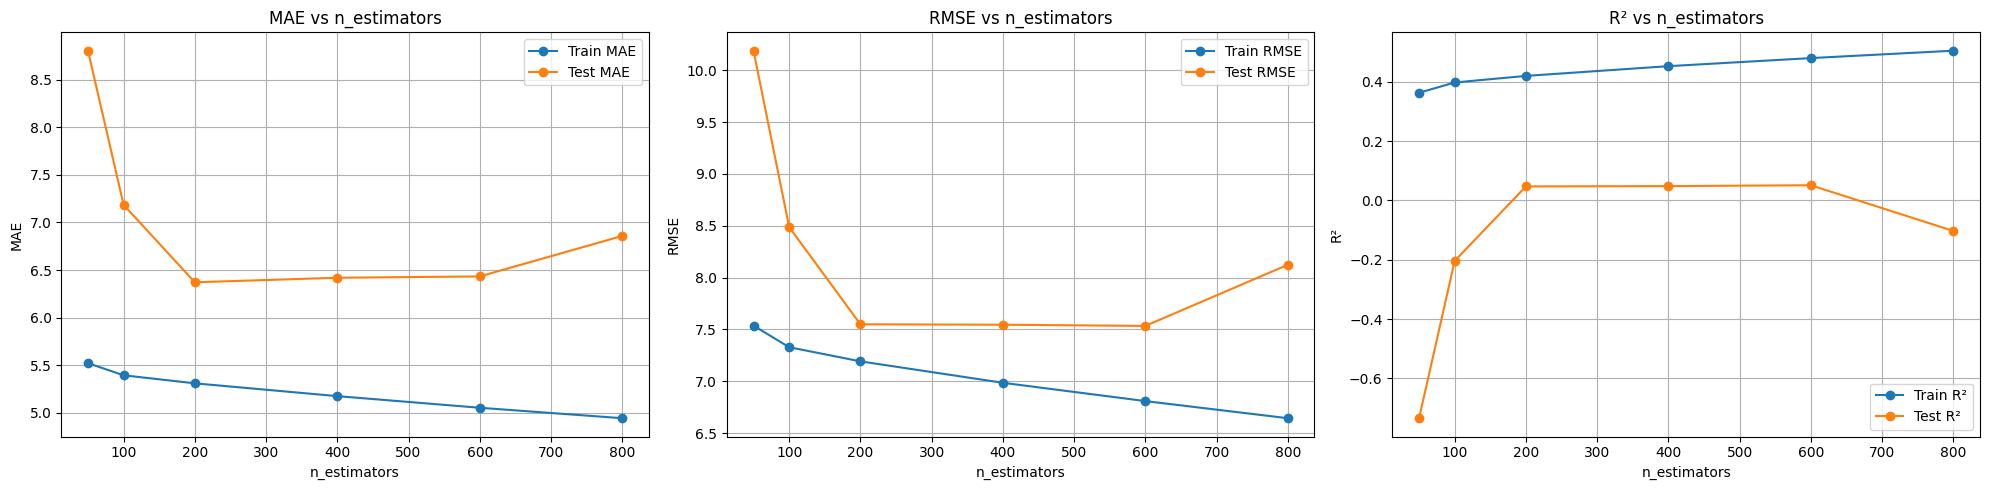


Mejor n_estimators según MAE test: 200


In [ ]:
# ============================================
# 0. IMPORTS
# ============================================
#import numpy as np
#import pandas as pd

#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#import matplotlib.pyplot as plt

#from lightgbm import LGBMRegressor

# ============================================
# 1. PREPARAR GRILLA BASE
# ============================================
dfm = base_modelo.copy()

dfm["fecha"] = pd.to_datetime(dfm["fecha"], errors="coerce")
dfm = dfm.sort_values(["sector_id", "fecha"])
dfm = dfm.dropna(subset=["y_reg"]).copy()

# Variables predictoras
features = [
    "edad_media", "prop_mujer",

    "delitos_total_lag1",  "delitos_con_arma_lag1",
    "delitos_total_lag2",  "delitos_con_arma_lag2",
    "delitos_total_lag3",  "delitos_con_arma_lag3",
    "delitos_total_lag4",  "delitos_con_arma_lag4",
    "delitos_total_lag5",  "delitos_con_arma_lag5",
    "delitos_total_lag6",  "delitos_con_arma_lag6",
    "delitos_total_lag7",  "delitos_con_arma_lag7",

    "anio", "mes", "dia_semana", "es_fin_semana"
]

X = dfm[features]
y = dfm["y_reg"]

# ============================================
# 2. SPLIT TEMPORAL 80/20
# ============================================
fechas_unicas = np.sort(dfm["fecha"].unique())
idx_corte = int(len(fechas_unicas) * 0.8)
fecha_corte = fechas_unicas[idx_corte]

mask_train = dfm["fecha"] <= fecha_corte
mask_test  = dfm["fecha"] >  fecha_corte

X_train, X_test = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Train:", X_train.shape, " Test:", X_test.shape)

# ============================================
# 3. EXPERIMENTO: n_estimators
# ============================================
n_estimators_values = [50, 100, 200, 400, 600, 800]

mae_train_list = []
mae_test_list  = []
rmse_train_list = []
rmse_test_list  = []
r2_train_list  = []
r2_test_list   = []

# Hiperparámetros fijos (usa aquí los que ya elegiste como buenos)
num_leaves_fijo   = 15
max_depth_fijo    = 15   # o 7, según tu experimento
learning_rate_fijo = 0.05

for n_est in n_estimators_values:
    print(f"\n=== Entrenando LightGBM con n_estimators={n_est} ===")

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("lgbm", LGBMRegressor(
                num_leaves=num_leaves_fijo,
                max_depth=max_depth_fijo,
                learning_rate=learning_rate_fijo,
                n_estimators=n_est,
                random_state=42,
                n_jobs=-1
        ))
    ])

    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    mae_train_list.append(mean_absolute_error(y_train, y_pred_train))
    mae_test_list.append(mean_absolute_error(y_test,  y_pred_test))

    rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    rmse_test_list.append(np.sqrt(mean_squared_error(y_test,  y_pred_test)))

    r2_train_list.append(r2_score(y_train, y_pred_train))
    r2_test_list.append(r2_score(y_test,  y_pred_test))

# ============================================
# 4. SUBPLOTS HORIZONTALES
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ------------ MAE ------------
axes[0].plot(n_estimators_values, mae_train_list, marker="o", label="Train MAE")
axes[0].plot(n_estimators_values, mae_test_list,  marker="o", label="Test MAE")
axes[0].set_title("MAE vs n_estimators")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("MAE")
axes[0].grid(True)
axes[0].legend()

# ------------ RMSE ------------
axes[1].plot(n_estimators_values, rmse_train_list, marker="o", label="Train RMSE")
axes[1].plot(n_estimators_values, rmse_test_list,  marker="o", label="Test RMSE")
axes[1].set_title("RMSE vs n_estimators")
axes[1].set_xlabel("n_estimators")
axes[1].set_ylabel("RMSE")
axes[1].grid(True)
axes[1].legend()

# ------------ R² ------------
axes[2].plot(n_estimators_values, r2_train_list, marker="o", label="Train R²")
axes[2].plot(n_estimators_values, r2_test_list,  marker="o", label="Test R²")
axes[2].set_title("R² vs n_estimators")
axes[2].set_xlabel("n_estimators")
axes[2].set_ylabel("R²")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()

# ============================================
# 4B. EXPORTACIÓN VECTORIAL (SVG)
# ============================================
plt.savefig("lightgbm_experimento_n_estimators.svg", format="svg", bbox_inches="tight")

# (Opcional) también PDF o PNG de alta resolución:
# plt.savefig("lightgbm_experimento_n_estimators.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("lightgbm_experimento_n_estimators.png", dpi=300, bbox_inches="tight")

plt.show()

# ============================================
# 5. IMPRIMIR EL ÓPTIMO SEGÚN MAE TEST
# ============================================
best_idx = int(np.argmin(mae_test_list))
best_n_estimators = n_estimators_values[best_idx]

print(f"\nMejor n_estimators según MAE test: {best_n_estimators}")
